# Getting started with Random Matrix Theory: Wigner semicircle

Author: Mirco Milletari' <milletari@gmail.com> 

In this notebook we give a simple numerical validation of the Wigner semicircle distribution discussed in the blog article. In order to run this notebook you need python3 installed together with Numpy, timeit (optional) and Matplotlib. In case you do not have it, I suggest to install the anaconda distribution for simplicity. This notebook has been tested on the following configuration: 

- processor: 3.5 GHz Dual-Core Intel Core i7.
- Memory: 16 GB 2133 MHz LPDDR3 memory.

all the reported timings refer to this configuration. 

For the sake of cleanliness, I moved the utility functions in a separate file in `utilities/rm_utils.py` where you can get into details of the evaluation.

In [1]:
import sys 
import numpy as np
from numpy.linalg import eigvalsh
from matplotlib import pyplot as plt
from timeit import default_timer 

#set of utility functions 
from utilities.rm_utils import normal, rm_sampling, wigner, rmse, get_bulk_edge_values 

print('system version:', sys.version, "\n")
print('numpy version:', np.__version__)

system version: 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)] 

numpy version: 1.18.1


It is convenient to define a random number generator with a given seed, so that all the expressions will be reproducible throughout the notebook. 

In [2]:
rng = np.random.default_rng(seed = 0)

We will be using numpy's normal distribution to generate instances of the random matrix. Let us check below how this works for the simple scalar case and compare the numerical result to its analytical expression: 

$$  p(x) =  \frac{1}{\sqrt{2 \pi \sigma^2} } e^{- \frac{x^2}{2 \sigma^2} } \equiv \mathcal{N}(0,\sigma)$$

Note that below we are using $\sigma = 1/\sqrt{N}$ in order to make contact with the normalization used for the Random Matrix result. 

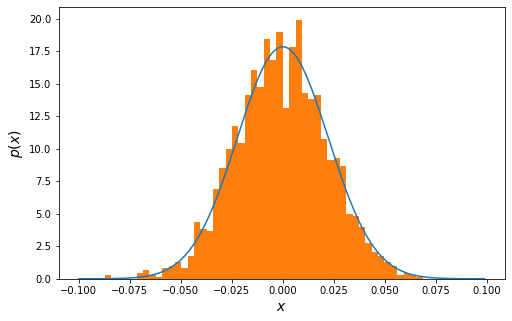

In [3]:
N = 2000 
sigma = N**(-0.5)
x = rng.normal(scale= sigma, size= N).astype(np.float32)

z = np.arange(-.1,.1, .001, dtype= np.float32)
gauss = normal(z, sigma)

plt.figure(figsize=(8, 5))
plt.plot(z,gauss)
plt.hist(x, bins= 50,density=True)
plt.xlabel(r"$x$", size= 14)
plt.ylabel(r"$p(x)$", size= 14)
plt.show()

## Warm-up: generating a (small) single instance

As a first step we generate a Random Matrix (RM) instance $X$ using numpy's random library. We are interested in RMs whose entries are i.i.d. Gaussian distributed. We generate the RM $X$ by sampling from the normal distribution; however, the result will not be automatically symmetric. We can get the desired symmetric matrix by using the following formula: 

$$X_s = \frac{X+X^T}{\sqrt{2} }$$

where the normalization has been chosen to conform to the one used in the derivation of the analytical results.
Let us check this explicitly with a small matrix. We create a square matrix with $N= 10$ and matrix elements sampled from a normal distribution centered in $0$ with variance $\sigma = 1/\sqrt{N}$ (see blog post): 

In [4]:
N= 10
sigma = N**(-0.5)
X = rng.normal(scale= sigma, size=(N,N)).astype(np.float32)
Xs= (X+X.T)/2**(0.5)

And simply check the symmetric condition $X_{ij} = X_{ji}$ for some choice of $i$ and $j$: 

In [5]:
X[1,2] == X[2,1]

False

In [6]:
Xs[1,2] == Xs[2,1]

True

You can check all the elements at once using the equivalent matrix expression: $X_s = X_s^T$:  

In [7]:
(Xs == Xs.T).all()

True

Moving to the eigenvalues, we can easily get them using numpy's linear algebra library; in particular, we are going to use [eigvalsh](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigvalsh.html#numpy.linalg.eigvalsh), that is numerically optimized to evaluate eigenvalues of real symmetric (and complex hermitian) matrices. Due to their simmetry, symmetric matrices have $N(N-1)/2$ independent elements, so the numpy function is evaluated only using  the upper/lower triangular part of the matrix.

These are the 10 eigenvalues of $X_s$ and their plot: 

In [8]:
lambdas= eigvalsh(Xs).astype(np.float32)
lambdas

array([-2.0356128 , -1.0917712 , -0.9628108 , -0.4324862 , -0.07590077,
        0.25616756,  0.52405363,  0.68646526,  1.3706948 ,  1.8910004 ],
      dtype=float32)

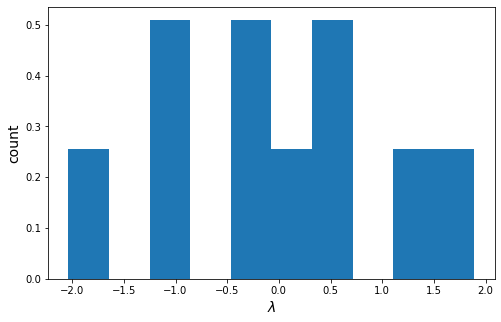

In [9]:
plt.figure(figsize=(8, 5))
plt.hist(lambdas, bins= N, density = True )
plt.xlabel(r"$\lambda$", size= 14)
plt.ylabel("count", size= 14)
plt.show()

Note that we will always plot normalized histograms as we are interested in distributions. However, this is not much of a distribution, as this is the result of a single realization (instance) of the random matrix. In the next section we are going to sample a larger portion of the distribution and show how the result depends on matrix size. 

## Sampling 

In this section we move on sampling the parameter space for different sizes of the random marix $X$. For  convenience I have defined a sampling function that performs the operations described in the previous section multiple times. 

Let us consider the same matrix size $N=10$ and draw 100 samples of it 

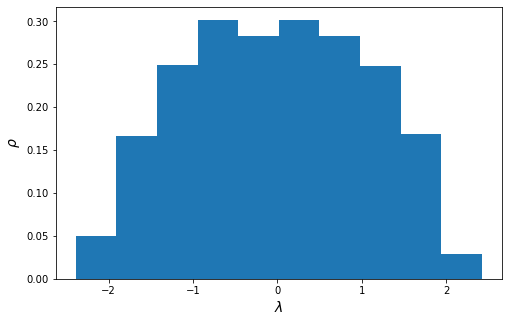

In [10]:
N = 10
n_samples = 100

lambdas = rm_sampling(n_samples, N, rng)

plt.figure(figsize=(8, 5))
plt.hist( lambdas, bins= int(n_samples**(0.5)), density=True ) 
plt.xlabel(r"$\lambda$", size= 14)
plt.ylabel(r"$\rho$", size= 14)
plt.show()

Now this starts looking like a distribution, even though it is still quite choppy. As we draw more samples, the distribution begins to take a better shape: 

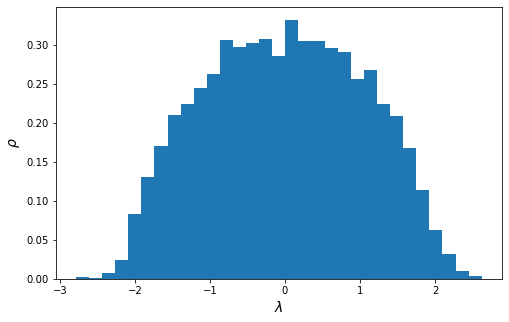

In [11]:
n_samples= 1000
N = 10

lambdas = rm_sampling(n_samples, N, rng)

plt.figure(figsize=(8, 5))
plt.hist( lambdas, bins= int(n_samples**(0.5)), density = True ) 
plt.xlabel(r"$\lambda$", size= 14)
plt.ylabel(r"$\rho$", size= 14)
plt.show()

### Wigner law: 

At this point we can compare the numerical result with the Wigner law we found in the blog (link); for convenience, let me rewrite the final result below: 

$\begin{equation}
    \rho(\lambda) =  \Bigg\{  \begin{matrix} 0 & |\lambda| > 2 \\ 
        \frac{1}{2\pi} \sqrt{4- \lambda^2} & |\lambda|<2 
    \end{matrix} 
\end{equation}$.

We can visualize this function in its domain of validity using the `wigner` utility function: 

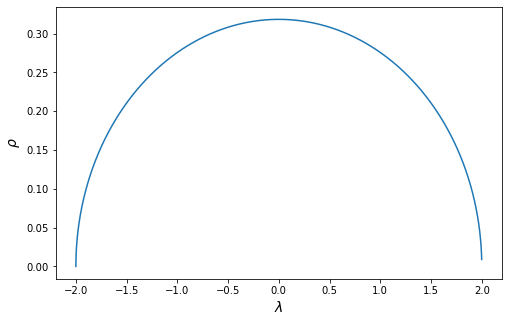

In [12]:
l = np.arange(-2.,2., .001, dtype= np.float32)
rho = wigner(l)

plt.figure(figsize=(8, 5))
plt.plot(l,rho)
plt.xlabel(r"$\lambda$", size= 14)
plt.ylabel(r"$\rho$", size= 14)
plt.show()

## Comparisons

Let us plot our findings together. You can see that the numerical results start looking like the analytical ones, even though there are some deviations, especially in the tails. You should not be surprised by that, since the analytical expression was obtained in the limit of large $N$ and clearly $N=10$ is not that large. The difference between the large and finite $N$ expression is generaaly known as a finite size correction, we come back to it later. 

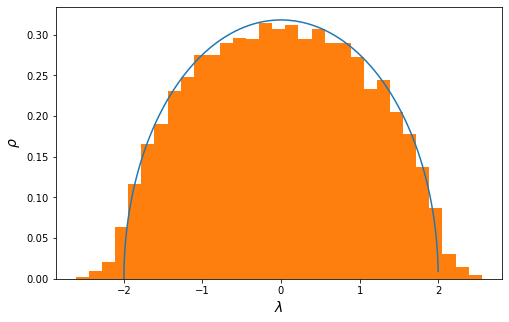

In [13]:
n_samples = 1000
N = 10
lambdas = rm_sampling(n_samples, N, rng)

plt.figure(figsize=(8, 5))
plt.plot(l,rho)
plt.hist( lambdas, bins= int(n_samples**(0.5)), density= True)
plt.xlabel(r"$\lambda$", size= 14)
plt.ylabel(r"$\rho$", size= 14)
plt.show()

Let us now run our sampling experiment for a larger RM, say $N=500$. Note that depending on your machine, this may take a while; I report my running time below to give you an idea of how long it takes on my laptop: 

In [14]:
start = default_timer()
N = 500
n_samples = 1000
lambdas = rm_sampling(n_samples, N, rng)

print('sampling completed in {} s'.format(default_timer()- start))

sampling completed in 24.026094872 s


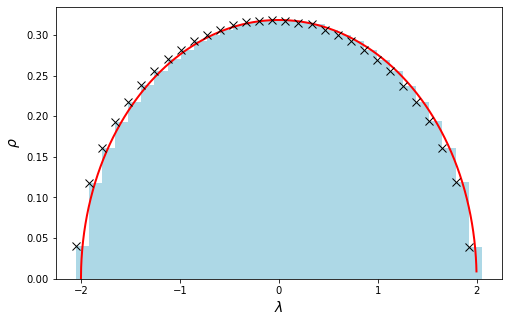

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(l,rho, color= 'red', linewidth=2)
r= plt.hist( lambdas, bins=int(n_samples**(0.5)), density= True, color= 'lightblue')
plt.plot(r[1][:-1], r[0], marker='x', linestyle=' ', markersize=8, color= 'black')
plt.xlabel(r"$\lambda$", size= 14)
plt.ylabel(r"$\rho$", size= 14)
plt.show()

You can see how the tails now "shrinks" to be almost inside the boundaries of the semicircle. Here I have also plotted the the bin value of the numerics as a "x" to better show the difference. Clearly the result gets better as the matrix size increases. To have a better and quantitative understading of what "better means", in the next section I evaluate the error between the numerical and analytical expression as a function of $N$. 

## Finite Size Error

In this last section I present a simple scaling analysis of the result. In particular, we are going to evaluate the Mean SquareRoot error (MSRE) between the numerical and analytical result as a function of the matrix size. For completness, let me remind you its definition: 

$$ rmse(\rho, \bar{\rho}) = \sqrt{ \frac{1}{N} \sum_{i=1}^N (\rho_i - \hat{\rho}_i )^2 } $$ 

where $\rho$ is the "measured" numerical value and $\hat{\rho}$ the analytical expression obtained in the large $N$ limit. In `rm_utils.py` I have defined two functions: 

- rmse: is just evaluating the rmse as explained above. 
- get_bulk_edge_values: separates the bulk numeriacal eigenvalues, i.e. those $\lambda \in [-2, 2]$ from the tails. 

What we want to verify is that $rmse(\rho_b, \bar{\rho}) \to 0$ as $N$ increases (b stands for bulk)as well as the values of the tails. For consistency, I will avaluate the latter in terms od the error $rmse(\rho_t, 0)$ for the tails ... I know it is a bit of an overkill, but it doesn't cost us much more effort :)    

Note that running this section may take a while, depending on your machine; the reported running time refers to the configuration described at the beginning of the notebook. 

In [16]:
sizes=[10, 50, 100, 300, 500, 1000] 
n_samples= 1000

bulk_errors = []
tails_errors= []

data = []

start=default_timer()

for n in sizes:

    lambdas = rm_sampling(n_samples, n, rng)
    counts, bins = np.histogram(lambdas, bins= n, density=True)

    bulk_rho, bulk_lambdas, tails_rho, tails_lambdas = get_bulk_edge_values(counts.astype(np.float32), 
                                                                        bins.astype(np.float32)
                                                                       )
        
    rho_n = wigner(bulk_lambdas)
    bulk_errors.append(rmse(bulk_rho, rho_n))
    tails_errors.append(rmse(tails_rho, 0))
    
print('sampling of {} random matrices completed in {} s'.format( len(sizes), default_timer()- start))

sampling of 6 random matrices completed in 94.316317216 s


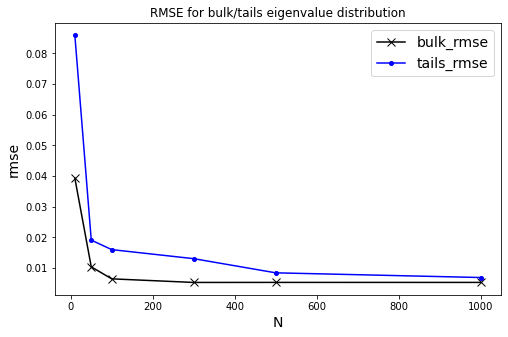

In [17]:
fig, ax = plt.subplots(figsize= [8,5])

ax.plot(sizes, bulk_errors, marker='x', markersize=8, color= 'black', label='bulk_rmse')
ax.plot(sizes, tails_errors, marker='.', markersize=8, color= 'blue', label='tails_rmse')
ax.set_title('RMSE for bulk/tails eigenvalue distribution')
ax.set_xlabel('N', size=14)
ax.set_ylabel('rmse', size=14)
ax.legend(prop={'size': 14})
plt.show()

You can see how the error goes to zero as the matrix size increases, both for the bulk and the tails of the distribution.